In [204]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from utils import *
import seaborn as sns

In [205]:
# plotting parameters

sns.set_palette("muted")  
plt.style.use("default")

method_styles = {
    "Unimodal (Random)": {"color": "#2B6C9A", "linestyle": ":"},  
    "Unimodal (Active Learning)": {"color": "#2B6C9A", "linestyle": "-"}, 
    
    "Multimodal (Random)": {"color": "#E89C5C", "linestyle": ":"},  
    "Multimodal (Active Learning)": {"color": "#E89C5C", "linestyle": "-"},  

    "Fully supervised (unimodal)": {"color": "#739DBB", "linestyle": "--"}, 
    "Fully supervised (multimodal)": {"color": "#F3BE90", "linestyle": "--"}, 
}

In [206]:
def load_results(result_path, prefix):
    results_df = pd.read_csv(result_path, index_col=0)
    
    list_names = ['F-score', 'Balanced Accuracy', 'Misclassified Samples','Total Annotated Data','weighted F-score']
        
    grouped_mean = results_df.groupby(['Base_name', 'Iteration'])[list_names].mean()
    grouped_std = results_df.groupby(['Base_name', 'Iteration'])[list_names].std()
    
    grouped_mean.reset_index(inplace=True)
    grouped_std.reset_index(inplace=True)
    
    grouped_mean['Base_name'] = prefix + '_' + grouped_mean['Base_name']
    grouped_std['Base_name'] = prefix + '_' + grouped_std['Base_name']
    
    return grouped_mean, grouped_std
    
    


In [207]:
dataset = 'mouse_kidney' # 'breast', 'human_kidney', 'mouse_kidney', 'Sample_SN048_A121573_Rep1'
dataset_to_validate ='annotation' # annotation, test

# flag telling if we want to include fully supervised results, this makes sense only for the test set
include_fully_supervised = True if dataset_to_validate == 'test' else False


all_metrics = ['F-score', 'Balanced Accuracy', 'Misclassified Samples','weighted F-score']
metrics_to_plot = ['weighted F-score','Misclassified Samples']

base_data_path = f"../../config_files/experiments/{dataset}"

exp_1_path =  f'{base_data_path}/unimodal/'
exp_1_prefix = "unimodal"

exp_2_path =  f'{base_data_path}/multimodal/'
exp_2_prefix = "multimodal"

save_dir = "../../results/reproduce_paper_results/"
os.makedirs(save_dir, exist_ok=True)

In [208]:

results_path = f'results_{dataset_to_validate}.csv'
classification_reports_path = f'classification_reports_{dataset_to_validate}.csv'

fully_supervised_path = f'{base_data_path}/fully_supervised/results_{dataset_to_validate}.csv'
fully_supervised_classification_reports_path = f'{base_data_path}/fully_supervised/classification_reports_{dataset_to_validate}.csv'


In [209]:
# load results
grouped_mean_1, grouped_std_1 = load_results(os.path.join(exp_1_path, results_path), exp_1_prefix)
grouped_mean_2, grouped_std_2 = load_results(os.path.join(exp_2_path, results_path), exp_2_prefix)

fully_supervised_grouped_mean, fully_supervised_grouped_std = load_results(fully_supervised_path, 'Fully_supervised')

# combine results from group 1 and group 2
grouped_mean = pd.concat([grouped_mean_1, grouped_mean_2])
grouped_std = pd.concat([grouped_std_1, grouped_std_2])

base_names = grouped_mean['Base_name'].unique()

In [210]:
# read fully supervised results to get total data points (for % of misclassified samples)
supervised_path = fully_supervised_path 
df_supervised = pd.read_csv(supervised_path, index_col=0)
df_supervised = df_supervised.groupby(['Base_name', 'Iteration'])[['F-score', 'Balanced Accuracy', 'Misclassified Samples','Total Annotated Data','weighted F-score']].mean()
df_supervised.reset_index(inplace=True)

total_annotated_spots = df_supervised['Total Annotated Data'].unique()
total_annotated_spots = total_annotated_spots[0]

total_number_of_spots = fully_supervised_grouped_mean['Total Annotated Data'].unique()
total_number_of_spots = total_number_of_spots[0]


print(f'Total annotated spots: {total_annotated_spots} out of {total_number_of_spots}')

Total annotated spots: 2806.0 out of 2806.0


In [211]:
grouped_mean['Total Annotated Data'] = (grouped_mean['Total Annotated Data'] /total_annotated_spots)*100
grouped_std['Total Annotated Data'] = (grouped_std['Total Annotated Data'] /total_annotated_spots)*100

grouped_mean['Misclassified Samples'] = grouped_mean['Misclassified Samples'] / total_number_of_spots
grouped_std['Misclassified Samples'] = grouped_std['Misclassified Samples'] / total_number_of_spots

fully_supervised_grouped_mean['Misclassified Samples'] = fully_supervised_grouped_mean['Misclassified Samples'] / total_number_of_spots
fully_supervised_grouped_std['Misclassified Samples'] = fully_supervised_grouped_std['Misclassified Samples'] / total_number_of_spots


weighted F-score
Misclassified Samples


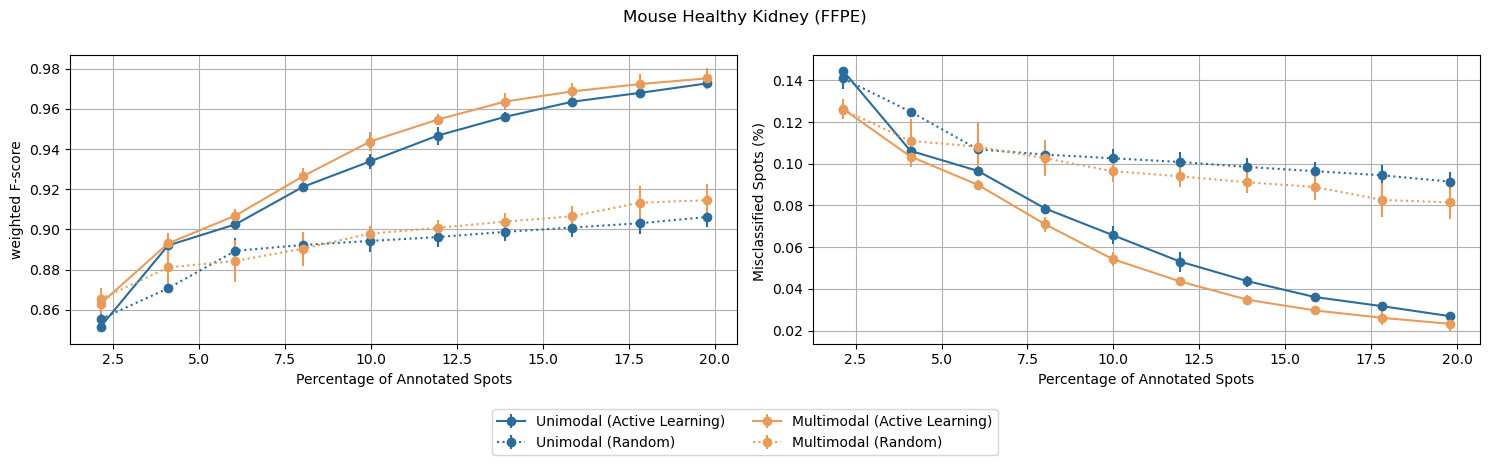

In [212]:

# Initialize a list to store handles and labels for the legend
handles = []
labels = []

if len(metrics_to_plot) == 2:
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    axes = axes.flatten()
else:
    
    fig, axes = plt.subplots(2, len(metrics_to_plot)//2, figsize=(15, 8))
    axes = axes.flatten()
    

for ax, metric in zip(axes, metrics_to_plot):
    print(metric)
    for i, base_name in enumerate(base_names):
 
        color = method_styles[extract_base_name(base_name, fully_supervised=False)]['color']
        style = method_styles[extract_base_name(base_name, fully_supervised=False)]['linestyle']
        
        line = ax.errorbar(grouped_mean[grouped_mean['Base_name'] == base_name]['Total Annotated Data'],
                           grouped_mean[grouped_mean['Base_name'] == base_name][metric],
                           yerr=grouped_std[grouped_std['Base_name'] == base_name][metric],
                           label=base_name, color=color, linestyle=style,fmt='o')
        
        # Collect the handle and label for the legend
        name = extract_base_name(base_name, fully_supervised=False)
        if name not in labels:
            handles.append(line)
            labels.append(name)
    
    if include_fully_supervised:
        # total iterations
        iters = grouped_mean[grouped_mean['Base_name'] == base_name]['Total Annotated Data'].values
        for model in fully_supervised_grouped_mean['Base_name'].unique():
            fs_metric = fully_supervised_grouped_mean[fully_supervised_grouped_mean['Base_name'] == model][metric].values[0]
            fs_std = fully_supervised_grouped_std[fully_supervised_grouped_std['Base_name'] == model][metric].values[0]
            
            color = method_styles[extract_base_name(model, fully_supervised=True)]['color']
            style = method_styles[extract_base_name(model, fully_supervised=True)]['linestyle']
            
            fs_line = ax.errorbar(iters, [fs_metric]*len(iters), yerr=[fs_std]*len(iters), color=color, linestyle=style, label={model}, fmt='o')
            
            # Add fully supervised line handle and label if not already added
            if f'{model}' not in labels:
                handles.append(fs_line)
                labels.append(f'{model}')

    # set limits to y axis
    ax.set_xlabel('Percentage of Annotated Spots')
    if metric == 'Misclassified Samples':
        ax.set_ylabel('Misclassified Spots (%) ')
    else:
        ax.set_ylabel(metric)
    ax.grid()

# Add the dataset as the title of the whole plot
fig.suptitle(f'{get_title(dataset)}')

# Create a legend for the plot below the subplots
if len(labels) <4:
    fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.07))
else:
    fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels)//2, bbox_to_anchor=(0.5, -0.15))

# Adjust layout to make room for the legend
fig.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig(f'{save_dir}/{dataset}_{dataset_to_validate}.png', dpi=300,bbox_inches='tight')
# Show the plot
plt.show()